In [1]:
from airsenal.framework.utils import *
from airsenal.framework.bpl_interface import get_fitted_team_model
from airsenal.framework.season import get_current_season, CURRENT_TEAMS

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import jax.numpy as jnp

%matplotlib inline

In [2]:
model_team = get_fitted_team_model(get_current_season(), NEXT_GAMEWEEK, session)

Fitting team model...


sample: 100%|███████| 1500/1500 [00:13<00:00, 112.92it/s, 63 steps of size 5.73e-02. acc. prob=0.94]


Adding BRE to team model with covariates


In [3]:
# extract indices of current premier league teams
# val-1 because 1-indexed in model but 0-indexed in python
current_idx = {team: idx for idx, team in enumerate(model_team.teams)
               if team in CURRENT_TEAMS}

top6 = ['MCI', 'LIV', 'TOT', 'CHE', 'MUN', 'ARS']

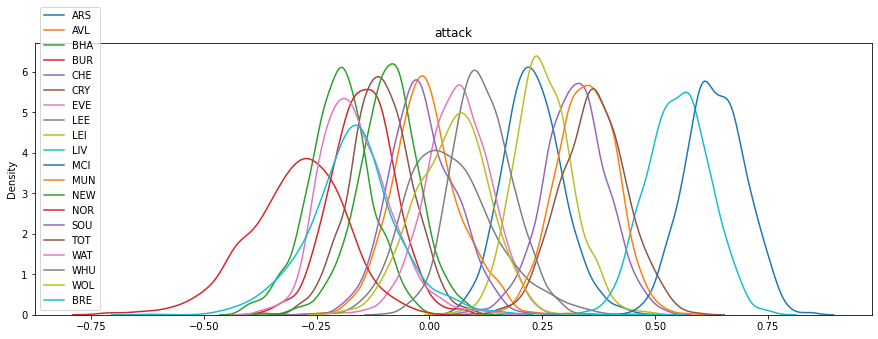

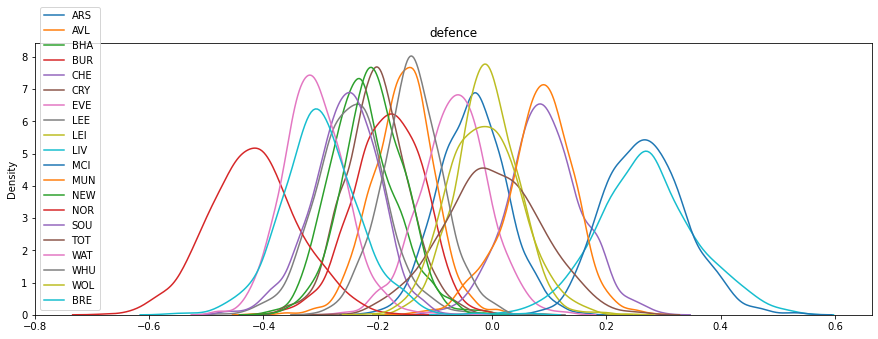

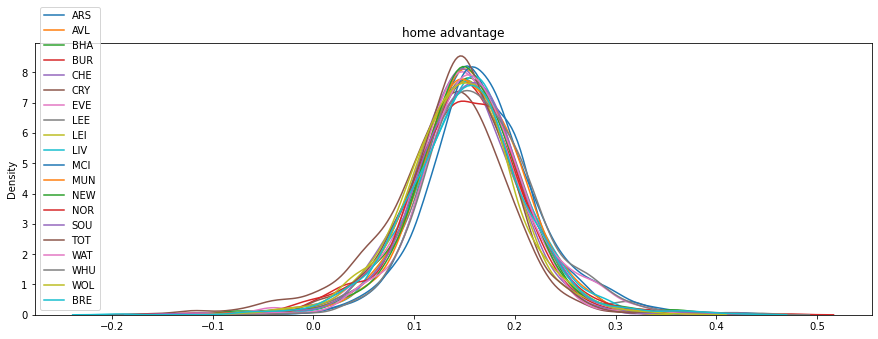

In [4]:
ax = plt.figure(figsize=(15, 5)).gca()
for team, idx in current_idx.items():
    sns.kdeplot(model_team.attack[:, idx], label=team)
plt.title('attack')
plt.legend()

ax = plt.figure(figsize=(15, 5)).gca()
for team, idx in current_idx.items():
    sns.kdeplot(model_team.defence[:, idx], label=team)
plt.title('defence')
plt.legend()

ax = plt.figure(figsize=(15, 5)).gca()
for team, idx in current_idx.items():
    sns.kdeplot(model_team.home_advantage[:, idx], label=team)
plt.title('home advantage')
plt.legend()

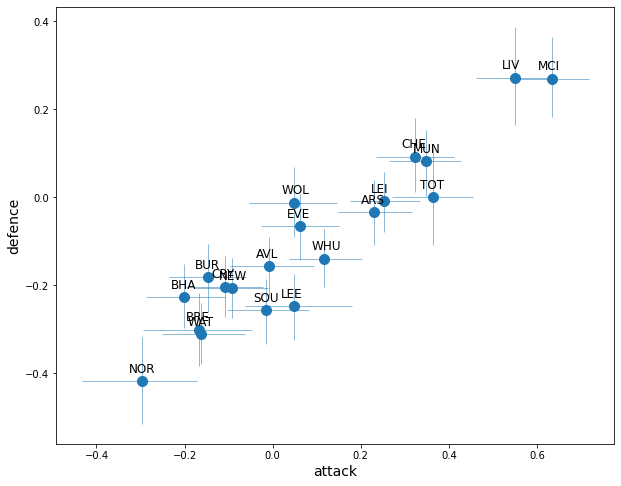

In [5]:
a_mean = model_team.attack.mean(axis=0)
b_mean = model_team.defence.mean(axis=0)

a_conf95 = np.abs(np.quantile(model_team.attack,[0.025, 0.975], axis=0) - a_mean)
b_conf95 = np.abs(np.quantile(model_team.defence, [0.025, 0.975], axis=0) - b_mean)
a_conf80 = np.abs(np.quantile(model_team.attack,[0.1, 0.9], axis=0) - a_mean)
b_conf80 = np.abs(np.quantile(model_team.defence, [0.1, 0.9], axis=0) - b_mean)

fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.set_aspect('equal')
select_idx = jnp.array(list(current_idx.values()), dtype=int)
plt.errorbar(a_mean[select_idx],
             b_mean[select_idx],
             xerr=a_conf80[:, select_idx],
             yerr=b_conf80[:, select_idx],
             marker='o', markersize=10,
             linestyle='', linewidth=0.5)
plt.xlabel('attack', fontsize=14)
plt.ylabel('defence', fontsize=14)

for team, idx in current_idx.items():
    ax.annotate(team,
                (a_mean[idx]-0.03, b_mean[idx]+0.02), 
                fontsize=12)


Text(0.5, 1.0, 'Defence Coefficients (Covariates)')

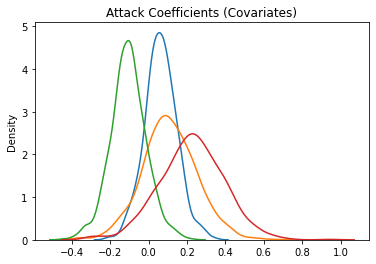

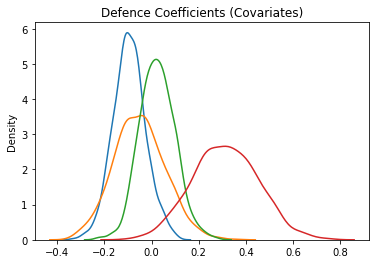

In [6]:
plt.figure()
for i in range(model_team.attack_coefficients.shape[1]):
    sns.kdeplot(model_team.attack_coefficients[:, i])
plt.title("Attack Coefficients (Covariates)")

plt.figure()
for i in range(model_team.defence_coefficients.shape[1]):
    sns.kdeplot(model_team.defence_coefficients[:, i])
plt.title("Defence Coefficients (Covariates)")

(-0.2212300643324852, 0.528213982284069)

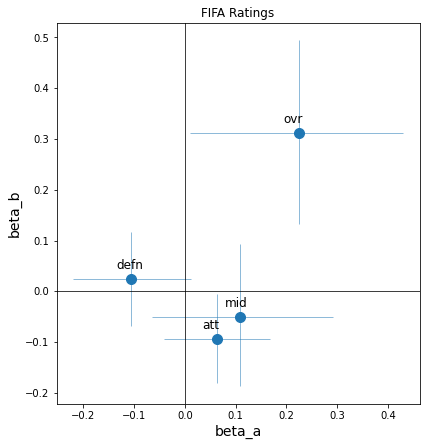

In [7]:
beta_a_mean = model_team.attack_coefficients.mean(axis=0)
beta_b_mean = model_team.defence_coefficients.mean(axis=0)

beta_a_conf95 = np.abs(np.quantile(model_team.attack_coefficients,[0.025, 0.975], axis=0) - beta_a_mean)
beta_b_conf95 = np.abs(np.quantile(model_team.defence_coefficients, [0.025, 0.975], axis=0) - beta_b_mean)
beta_a_conf80 = np.abs(np.quantile(model_team.attack_coefficients,[0.1, 0.9], axis=0) - beta_a_mean)
beta_b_conf80 = np.abs(np.quantile(model_team.defence_coefficients, [0.1, 0.9], axis=0) - beta_b_mean)

fig, ax = plt.subplots(1, 1, figsize=(7,7))
ax.set_aspect('equal')
plt.errorbar(beta_a_mean,
             beta_b_mean,
             xerr=beta_a_conf80,
             yerr=beta_b_conf80,
             marker='o', markersize=10,
             linestyle='', linewidth=0.5)
plt.xlabel('beta_a', fontsize=14)
plt.ylabel('beta_b', fontsize=14)
plt.title('FIFA Ratings')

for idx, feat in enumerate(["att", "mid", "defn", "ovr"]):
    ax.annotate(feat,
                (beta_a_mean[idx]-0.03, beta_b_mean[idx]+0.02), 
                fontsize=12)
    
xlim = ax.get_xlim()
ylim = ax.get_ylim()
plt.plot([0, 0], ylim, color='k', linewidth=0.75)
plt.plot(xlim, [0, 0], color='k', linewidth=0.75)
plt.xlim(xlim)
plt.ylim(ylim)

Text(0.5, 1.0, 'rho')

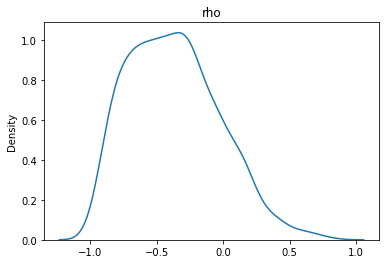

In [8]:
sns.kdeplot(model_team.rho)
plt.title("rho")

In [9]:
team_h = "MCI"
team_a = "MUN"

In [10]:
model_team.predict_concede_n_proba(2, team_h, team_a)

DeviceArray([0.19813643], dtype=float32)

In [11]:
model_team.predict_score_n_proba(2, team_h, team_a)

DeviceArray([0.26880637], dtype=float32)

In [12]:
model_team.predict_outcome_proba(team_h, team_a)

{'home_win': DeviceArray([0.5945194], dtype=float32),
 'away_win': DeviceArray([0.19107981], dtype=float32),
 'draw': DeviceArray([0.21440066], dtype=float32)}

In [13]:
model_team.predict_score_proba(team_h, team_a, 2, 2)

DeviceArray([0.0532574], dtype=float32)

MCI exp goals 2.060585
MUN exp goals 1.0856315


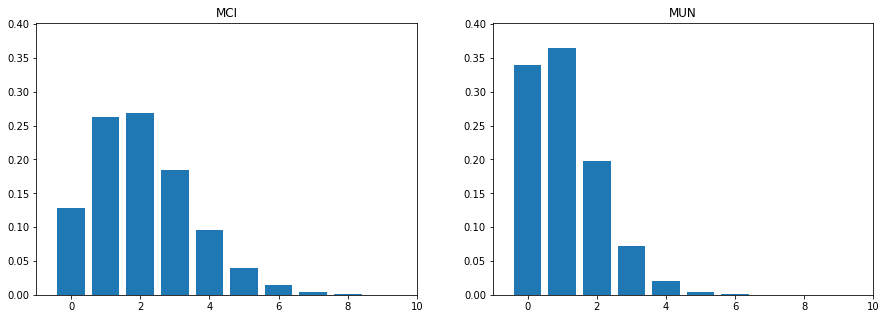

In [14]:
max_goals = 10

prob_score_h = [model_team.predict_score_n_proba(n, team_h, team_a)[0] for n in range(max_goals)]
print(team_h, "exp goals", sum([n*prob_score_h[n] for n in range(max_goals)])/sum(prob_score_h))

prob_score_a = [model_team.predict_score_n_proba(n, team_a, team_h, home=False)[0] for n in range(max_goals)]
print(team_a, "exp goals", sum([n*prob_score_a[n] for n in range(max_goals)])/sum(prob_score_a))

max_prob = 1.1*max(prob_score_h + prob_score_a)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.bar(range(max_goals), prob_score_h)
plt.ylim([0, max_prob])
plt.xlim([-1, max_goals])
plt.title(team_h)

plt.subplot(1,2,2)
plt.bar(range(max_goals), prob_score_a)
plt.ylim([0, max_prob])
plt.xlim([-1, max_goals])
plt.title(team_a);